# Figures for Estuarine Exchange Paper

In [8]:
from salishsea_tools import nc_tools, viz_tools, places, geo_tools, visualisations

from cmocean import cm
import copy
import matplotlib.pyplot as plt
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import netCDF4 as nc
from scipy.io import loadmat
import numpy as np
import xarray as xr

%matplotlib inline

## Map ##
copied heavily from http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-ben/raw/tip/notebooks/Maps.ipynb and then updated to cartopy from https://github.com/SalishSeaCast/analysis-ben/blob/master/notebooks/Maps.ipynb

In [18]:
plt.rcParams['font.size'] = 17

In [3]:
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
T_NEMO = xr.open_dataset('/home/sallen/MEOPAR/estuarine_flux_paper/older_plots/SalishSea_1h_20170903_20170903_grid_T.nc',
                        mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

Adding ticks along the thalweg.  Based on Karyn's notebook: https://github.com/SalishSeaCast/analysis-karyn/blob/master/notebooks/CLUSTER_UNIVERSAL/SalishSea_ThalwegMap.ipynb

In [4]:
var = T_NEMO.vosaline[23]
gdept = mask.gdept_0[0]
lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
lines = lines.astype(int)

thalweg_lon = grid.nav_lon.values[lines[:,0], lines[:,1]]
thalweg_lat = grid.nav_lat.values[lines[:,0], lines[:,1]]

dep_thal, xx_thal, var_thal = visualisations.load_thalweg(gdept, var, grid.nav_lon.values,
                                                          grid.nav_lat.values, lines)

distance_along_thalweg = xx_thal[0, 0]


In [5]:
dticks = np.arange(0, 800, 100)
dlen = dticks.shape[0]
iticks = np.zeros(dlen, dtype='int')
for ii in range(dlen):
    iticks[ii] = (np.abs(distance_along_thalweg - dticks[ii])).argmin()


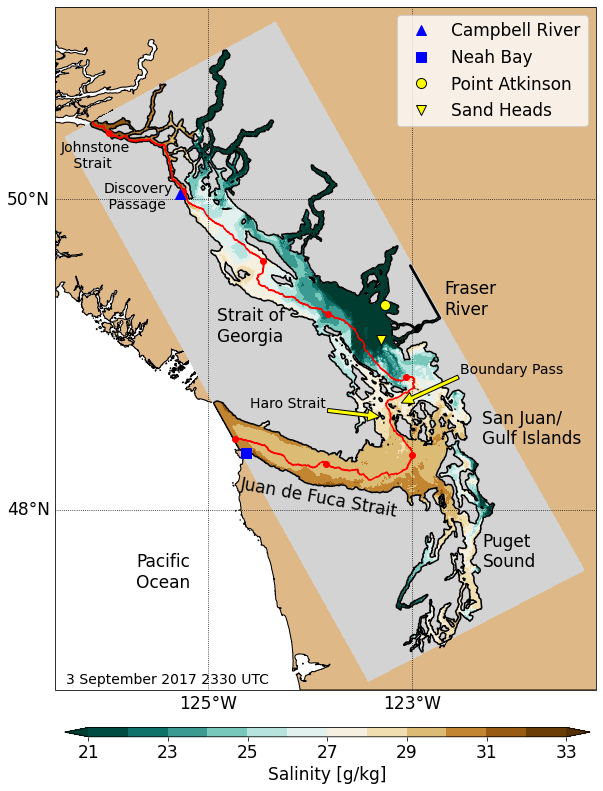

In [11]:
fig = plt.figure(figsize=(10, 13))
xlim, ylim = [-126.5, -121.2], [46.8, 51.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
C = ax.contourf(
    grid.nav_lon, grid.nav_lat, T_NEMO.vosaline.isel(time_counter=23, deptht=0), range(21, 34),
    cmap='BrBG_r', extend='both', transform=crs.PlateCarree(), zorder=2,
)
for attr, color in zip(['contourf', 'contour'], ['lightgray', 'k']):
    getattr(ax, attr)(
        grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...],
        levels=[-0.01, 0.01], colors=color, transform=crs.PlateCarree(), zorder=2,
    )

xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1, 2) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

ax.text(0.15, 0.15, 'Pacific\nOcean', transform=ax.transAxes)
ax.text(0.79, 0.18, 'Puget\nSound', transform=ax.transAxes)
ax.text(0.79, 0.36, 'San Juan/\nGulf Islands', transform=ax.transAxes)
ax.text(0.34, 0.255, 'Juan de Fuca Strait', transform=ax.transAxes, rotation=-10)
ax.text(0.3, 0.51, 'Strait of\nGeorgia', transform=ax.transAxes) #0.345, 0.702
ax.text(0.72, 0.55, 'Fraser\nRiver', transform=ax.transAxes)
ax.text(0.09, 0.705, 'Discovery\n Passage', transform=ax.transAxes, fontsize=14)
ax.text(0.01, 0.765, 'Johnstone\n   Strait', transform=ax.transAxes, fontsize=14)
ax.annotate('Haro Strait',
            xy=(0.6, 0.4), xycoords='axes fraction',
            xytext=(0.5, 0.43), textcoords='axes fraction', fontsize=14,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('Boundary Pass',
            xy=(0.64, 0.42), xycoords='axes fraction',
            xytext=(0.94, 0.48), textcoords='axes fraction', fontsize=14,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='top')

ax.plot(-125.2733, 50.0331, 'b^', transform=crs.PlateCarree(), label='Campbell River', markersize=10,
       zorder=3)
ax.plot(-124.6250, 48.3681, 'bs', transform=crs.PlateCarree(), label='Neah Bay', markersize=10)
ax.plot(-123.2646, 49.3304, 'o', color='yellow', transform=crs.PlateCarree(), label='Point Atkinson', markersize=10, markeredgecolor='k')
ax.plot(-123.3033, 49.1059, 'v', color='yellow', transform=crs.PlateCarree(), label='Sand Heads', markersize=10, markeredgecolor='k') #Latitude: 49.1059, Longitude: -123.3033

ax.legend(loc='upper right')


fig.subplots_adjust(bottom=0.15)
cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Salinity [g/kg]')
cbar.set_label(label='Salinity [g/kg]')
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)

ax.plot(thalweg_lon, thalweg_lat, 'r', transform=crs.PlateCarree(), markersize=1)
ax.plot(thalweg_lon[iticks], thalweg_lat[iticks], 'ro', transform=crs.PlateCarree())

ax.text(0.02, 0.01, '3 September 2017 2330 UTC', transform=ax.transAxes, fontsize=14);
plt.savefig('map_for_estuarine_exchange_v2.png')
plt.savefig('map_for_estuarine_exchange_v2.pdf')

## Inset Figure

In [12]:
myBrBG_r = copy.copy(plt.get_cmap('BrBG_r'))
myBrBG_r.set_under('darkgrey')

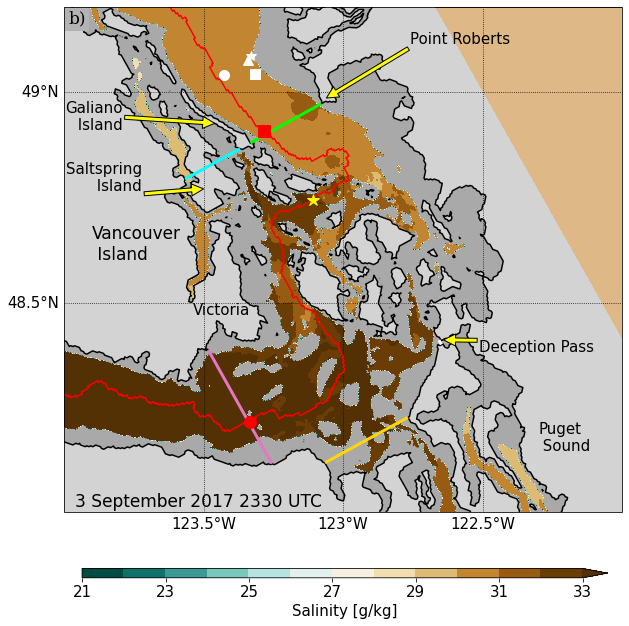

In [21]:
plt.rcParams['font.size'] = 15
mylabels = ['a)', 'b)', 'c)', 'd)']

fsi = 2
fig = plt.figure(figsize=(10, 13))
xlim, ylim = [-124, -122], [48, 49.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))
C = ax.contourf(
    grid.nav_lon, grid.nav_lat, T_NEMO.vosaline.isel(time_counter=23, deptht=25), range(21, 34),
    cmap=myBrBG_r, extend='both', transform=crs.PlateCarree(), zorder=2,
)
for attr, color in zip(['contourf', 'contour'], ['lightgray', 'k']):
    getattr(ax, attr)(
        grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...],
        levels=[-0.01, 0.01], colors=color, transform=crs.PlateCarree(), zorder=2,
    )

xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1, 0.5) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.top_labels, gl.right_labels = False, False

        
fig.subplots_adjust(bottom=0.0)
cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Salinity [g/kg]', extendfrac=[0, 0.05])
cbar.set_label(label='Salinity [g/kg]')
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)    

lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
lines = lines.astype(int)

thalweg_lon = grid.nav_lon.values[lines[:,0], lines[:,1]]
thalweg_lat = grid.nav_lat.values[lines[:,0], lines[:,1]]

ax.plot(thalweg_lon, thalweg_lat, 'r', transform=crs.PlateCarree(), markersize=1)

Victoria_sill_j = 178-1
Victoria_sill_i = np.arange(235,302+1)-1
vs_lon = grid.nav_lon[Victoria_sill_i, Victoria_sill_j]
vs_lat = grid.nav_lat[Victoria_sill_i, Victoria_sill_j]
ax.plot(vs_lon, vs_lat, 'tab:pink', linewidth=3, transform=crs.PlateCarree())

Point_Roberts_j = np.arange(262, 309+1)-1
Point_Roberts_i = 387-1
pr_lon = grid.nav_lon[Point_Roberts_i, Point_Roberts_j]
pr_lat = grid.nav_lat[Point_Roberts_i, Point_Roberts_j]
ax.plot(pr_lon, pr_lat, 'lime', linewidth=3, transform=crs.PlateCarree())

Gulf_Islands_j = np.arange(217, 253+1) -1
Gulf_Islands_i = 387 - 1
gi_lon = grid.nav_lon[Gulf_Islands_i, Gulf_Islands_j]
gi_lat = grid.nav_lat[Gulf_Islands_i, Gulf_Islands_j]
ax.plot(gi_lon, gi_lat, 'aqua', linewidth=3, transform=crs.PlateCarree())

Puget_Sound_j = np.arange(207, 262+1) - 1
Puget_Sound_i = 221 - 1
ps_lon = grid.nav_lon[Puget_Sound_i, Puget_Sound_j]
ps_lat = grid.nav_lat[Puget_Sound_i, Puget_Sound_j]
ax.plot(ps_lon, ps_lat, 'gold', linewidth=3, transform=crs.PlateCarree())

Discovery_j = 302-1
Discovery_i = np.arange(247, 248+1)-1
d_lon = grid.nav_lon[Discovery_i, Discovery_j]
d_lat = grid.nav_lat[Discovery_i, Discovery_j]
ax.plot(d_lon, d_lat, 'w', linewidth=3, transform=crs.PlateCarree())

for place, marker in zip(['Central node', 'East node', 'Delta BBL node', 'Delta DDL node'], ['o', 's', '^', '*']):
        mx, my = (places.PLACES[place]['lon lat'][0], places.PLACES[place]['lon lat'][1])  
        ax.plot(mx, my, 'w', markersize=10, marker=marker, transform=crs.PlateCarree())

mx, my = grid.nav_lon[258, 178], grid.nav_lat[258, 178]
ax.plot(mx, my, 'r', markersize=12, marker='o', transform=crs.PlateCarree())

mx, my = grid.nav_lon[388, 271], grid.nav_lat[388, 271]
ax.plot(mx, my, 'r', markersize=12, marker='s', transform=crs.PlateCarree())

mx, my = grid.nav_lon[344, 276], grid.nav_lat[344, 276]
ax.plot(mx, my, color='yellow', markersize=12, marker='*', transform=crs.PlateCarree())

ax.annotate('Point Roberts',
            xy=(0.47, 0.82), xycoords='axes fraction',
            xytext=(0.8, 0.95), textcoords='axes fraction', fontsize=13+fsi,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Puget\n Sound',
            xy=(0.6, 0.8), xycoords='axes fraction',
            xytext=(0.85, 0.12), textcoords='axes fraction', fontsize=13+fsi,
            )

ax.annotate('Victoria',
            xy=(0.5, 0.8), xycoords='axes fraction',
            xytext=(0.23, 0.39), textcoords='axes fraction', fontsize=13+fsi,
            )

ax.annotate('Deception Pass',
            xy=(0.8-0.12, 0.32+0.021), xycoords='axes fraction',
            xytext=(0.95, 0.34), textcoords='axes fraction', fontsize=13+fsi,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Saltspring\n Island',
            xy=(0.25, 0.64), xycoords='axes fraction',
            xytext=(0.14, 0.63), textcoords='axes fraction', fontsize=13+fsi,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('Galiano\n Island',
            xy=(0.27, 0.77), xycoords='axes fraction',
            xytext=(0.105, 0.75), textcoords='axes fraction', fontsize=13+fsi,
            arrowprops=dict(facecolor='yellow'),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('Vancouver\n Island',
            xy=(0.5, 0.8), xycoords='axes fraction',
            xytext=(0.05, 0.5), textcoords='axes fraction', fontsize=15+fsi,
            )

ax.text(0.008, 0.993, mylabels[1], transform=ax.transAxes,
    fontsize=17, verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

ax.text(0.02, 0.01, '3 September 2017 2330 UTC', transform=ax.transAxes, fontsize=15+fsi);
plt.savefig('inset_for_estuarine_exchange_v3.png')
plt.savefig('inset_for_estuarine_exchange_v3.pdf')